### すべての画像をサイコロ一つに分離してクロップせずに予測する方法

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

from sklearn.metrics import accuracy_score
from sklearn.cluster import SpectralClustering

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from timm.scheduler import CosineLRScheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models

from dsets import getOneDiceRotate90
from dsets import ImageDataset
from dsets import getOneDiceImage
from dsets import devideTwoImage
from dsets import devideThreeImage
from dsets import getIndexForEachDice

from models import RegNetWrapper
from models import ResNet18Wrapper

### Spectral Clusteringを使う場合

##### データの読み込み

In [4]:
one_dice_idx, two_dice_idx, three_dice_idx = getIndexForEachDice(data_type='test_denoised')

In [5]:
one_dice_imgs = getOneDiceImage(idx=one_dice_idx, data_type='test_denoised')
two_dice_imgs = devideTwoImage(idx=two_dice_idx, data_type='test_denoised')
three_dice_imgs = devideThreeImage(idx=three_dice_idx, data_type='test_denoised')

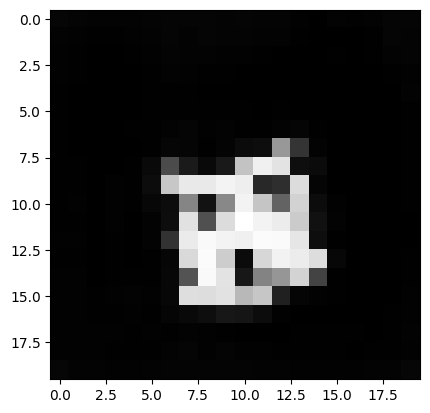

In [6]:
plt.imshow(one_dice_imgs[0], cmap='gray')
plt.show()

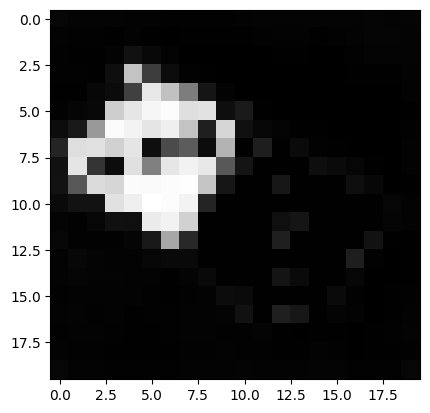

In [7]:
plt.imshow(two_dice_imgs[0], cmap='gray')
plt.show()

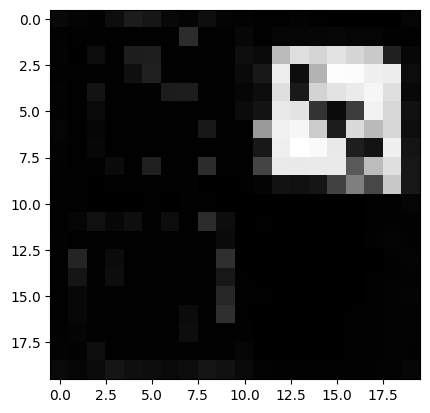

In [8]:
plt.imshow(three_dice_imgs[0], cmap='gray')
plt.show()

In [10]:
imgs_list = one_dice_imgs + two_dice_imgs + three_dice_imgs
len(imgs_list)

52973

##### 平均, 標準偏差の算出

In [11]:
image_ToTensor = transforms.ToTensor()

# テストデータの平均
test_imgs_sum = 0
for img in imgs_list:
    img_t = image_ToTensor(img)
    test_imgs_sum += torch.sum(img_t[0])

test_img_mean = test_imgs_sum / (20*20*len(imgs_list))
print(f'テストデータの平均: {test_img_mean}')

# 訓練データの標準偏差
test_img_L2 = 0
for img in imgs_list:
    img_t = image_ToTensor(img)
    test_img_L2 += torch.sum((img_t[0] - test_img_mean)**2)
test_img_std = torch.sqrt(test_img_L2/(20*20*len(imgs_list)))
print(f'テストデータの標準偏差: {test_img_std}')   

テストデータの平均: 0.11685798317193985
テストデータの標準偏差: 0.2702524662017822


##### データセットの作成

In [12]:
def testTransformer(img):
    img_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1166), (0.27025))
    ])
    
    img_t = img_transformer(img)

    return img_t

In [13]:
# Testデータ用のDataset
class TestDataset(Dataset):
    '''Test Dataset クラス (サイコロを一つ持つ画像)
    Attributes:
        imgs: testデータの画像のリスト
    '''
    def __init__(self, imgs):
        self.imgs = imgs
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.astype(np.uint8)
        img_t = testTransformer(img)
    
        return img_t

In [14]:
BATCH_SIZE = 128
test_ds = TestDataset(imgs=imgs_list)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

##### モデルの読み込み・予測

In [15]:
# RegNet32
class RegNet32Wrapper(nn.Module):
    def __init__(self):
        super().__init__()

        self.regnet32 = models.regnet_y_32gf(
            weights="RegNet_Y_32GF_Weights.IMAGENET1K_SWAG_E2E_V1"
        )

        self.regnet32.stem[0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.regnet32.fc = nn.Linear(3712, 6)

        self.head_softmax = nn.Softmax(dim=1)

    def forward(self, input_batch):
        logit = self.regnet32(input_batch)

        return logit, self.head_softmax(logit)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
model = RegNet32Wrapper()
model.load_state_dict(torch.load("/mnt/g/マイドライブ/MyStudy/MySIGNATE/SonyDice/models/one_dice_mass_produced_40T/regnet32/E22_2023-11-08_13-36.pt"))
model.to(device)

RegNet32Wrapper(
  (regnet32): RegNet(
    (stem): SimpleStemIN(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (trunk_output): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(232, 232, kernel_s

In [19]:
torch.cuda.empty_cache()

In [20]:
pred_label = torch.zeros(len(test_ds), dtype=torch.long)
model.eval()

for iter_num, X in tqdm(enumerate(test_dl), total=len(test_dl)):

    X = X.to(device)

    with torch.no_grad(), torch.autocast('cuda'):
        y_pred, y_softmax = model(X)
        _, label = torch.max(y_softmax, dim=1)
        pred_label[iter_num*BATCH_SIZE: (iter_num+1)*BATCH_SIZE] = label.detach() + 1

100%|██████████| 414/414 [00:27<00:00, 15.27it/s]


In [21]:
pred_label = pred_label.numpy()
pred_label

array([6, 6, 3, ..., 3, 2, 2])

##### 提出ファイルの作成

In [22]:
one_dice_rolls = pred_label[:len(one_dice_idx)]
devided_two_dice_rolls = pred_label[len(one_dice_idx):len(one_dice_idx)+len(two_dice_idx)*2]
devided_three_dice_rolls = pred_label[len(one_dice_idx)+len(two_dice_idx)*2:]

In [23]:
len(one_dice_rolls) + len(devided_two_dice_rolls) / 2 + len(devided_three_dice_rolls) / 3

24922.0

In [24]:
two_dice_rolls = []

for i, roll in enumerate(devided_two_dice_rolls):
    if i % 2 == 0:
        tmp = roll
    else:
        tmp += roll
        two_dice_rolls.append(tmp)

In [25]:
three_dice_rolls = []

for i, roll in enumerate(devided_three_dice_rolls):
    if i % 3 == 0:
        tmp = roll
    else:
        tmp += roll
        if i % 3 == 2:
            three_dice_rolls.append(tmp)

In [26]:
len(two_dice_rolls)

6663

In [27]:
len(three_dice_rolls)

10694

In [28]:
dice_rolls = []
submit_df = pd.read_csv('/mnt/c/Users/user/MyData/SonyDice/sample_submit.csv', header=None)

In [29]:
for i, idx in enumerate(one_dice_idx):
    submit_df.loc[idx, 1] = one_dice_rolls[i]

for i, idx in enumerate(two_dice_idx):
    submit_df.loc[idx, 1] = two_dice_rolls[i]

for i, idx in enumerate(three_dice_idx):
    submit_df.loc[idx, 1] = three_dice_rolls[i]

In [30]:
submit_df

,0,1
0,0,6
1,1,8
2,2,8
3,3,7
4,4,6
...,...,...
24917,24917,11
24918,24918,7
24919,24919,5
24920,24920,11


In [31]:
submit_df.to_csv('/mnt/c/Users/user/MyData/SonyDice/work/devide_dice-denoised_by_UNet-regnet32-not_crop-E22.csv', header=False, index=False)